In [1]:
import os
loc = 'drive/My Drive/Signature_Verification_CNN'

# **Importing Libraries**

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dropout


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPool2D,Concatenate,Lambda,Flatten,Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

# **Preparing the dataset**

In [5]:
import os
import cv2
from zipfile import ZipFile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations

def imagePreprocess(image,size):# Size in format img_width,img_height
    image=cv2.resize(image, size) 
    #(thresh, image) = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # grayscale to binary using threshold
    image = image/255
    return image
def getData(loc,name_file,size,dic):
    img_list = []
    l = len(name_file)
    counter = 0
    for name in name_file:
        if counter==int(l/4):
          print("25% Completed..")
        elif counter==int(l/2):
          print("50% Completed..")
        elif counter==int(3*l/2):
          print("75% Completed..")
        counter+=1

        try:
            img = cv2.imread(os.path.join(loc,name),0)
            img = imagePreprocess(img,size)
            img = img.reshape((size[0],size[1],1))
            img_list.append(name)
            dic[name] = img
        except:
            print("Couldn't import ",name,"in Location:",loc)
            continue
    print("100% Completed")
    return img_list    

def getImages(loc,size,dic):
    print("Getting Dataset Data..")
    real_names = os.listdir(os.path.join(loc,'full_org'))
    forg_names = os.listdir(os.path.join(loc,'full_forg'))
    img_real = getData(os.path.join(loc,'full_org'),real_names,size,dic)
    img_forg = getData(os.path.join(loc,'full_forg'),forg_names,size,dic)
    print("Data Import Complete!")
    return (np.asarray(img_real),np.asarray(img_forg))

def makePairs(real_img,forged_img,no_of_writers):
    y=[]
    x1=[]
    x2=[]
    length = len(real_img) # Length of both is supposed to be same
    for i in range(0,length,no_of_writers): # Real-Real samples
        combs = list(combinations(range(i,i+no_of_writers),2))
        for each in combs:
            x1.append(real_img[each[0]])
            x2.append(real_img[each[1]])
            y.append(1)
            x1.append(real_img[each[0]])
            x2.append(forged_img[each[1]])
            y.append(0)
    return [np.asarray(x1),np.asarray(x2),np.asarray(y)]

# **Dataset Generation**

### **Importing Data**

In [6]:
size= 96
imgsize = (size,size)
path_dataset = '/kaggle/input/cedarsigverif/Signature_Set2' # CEDAR
images_dictionary = {}

### **Dataset from Drive**
(CEDAR)

In [7]:
real_img,forged_img = getImages(path_dataset,imgsize,images_dictionary)
real_img = np.sort(real_img)
forged_img = np.sort(forged_img)
X1,X2,Y = makePairs(real_img,forged_img,24)
print(len(X1),len(X2),len(Y))

Getting Dataset Data..
25% Completed..
50% Completed..
Couldn't import  Thumbs.db in Location: /kaggle/input/cedarsigverif/Signature_Set2/full_org
100% Completed
25% Completed..
50% Completed..
Couldn't import  Thumbs.db in Location: /kaggle/input/cedarsigverif/Signature_Set2/full_forg
100% Completed
Data Import Complete!
30360 30360 30360


### **Shuffling Data**

In [8]:
import random
random.seed=35
mapIndexPosition = list(zip(X1,X2,Y))
random.shuffle(mapIndexPosition)
X1,X2,Y = zip(*mapIndexPosition)
Y = tf.cast(Y, tf.float32)

In [9]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=20)
# print(len(X_train),len(Y_train),len(X_val),len(Y_val))
partition = 2140  # 0.7 * len(X1)
X1_train, X1_val = X1[:partition], X1[partition:]
X2_train, X2_val = X2[:partition], X2[partition:]
Y_train , Y_val  = Y[:partition] , Y[partition:]

## **Generating Data**

In [10]:
def create_batch(x1,x2,startpoint,batch_size):
    fir=np.zeros((batch_size,imgsize[0],imgsize[0],1))
    sec=np.zeros((batch_size,imgsize[0],imgsize[0],1))
    counter=0
    for i in range(startpoint,startpoint+batch_size):
        fir[counter]=images_dictionary[x1[i]]
        sec[counter]=images_dictionary[x2[i]]
        counter+=1
    return fir,sec

In [11]:
def returnImageList(name_lis):
    length = len(name_lis)
    imgs = np.zeros((length,imgsize[0],imgsize[0],1))
    for i in range(0,length):
        imgs[i] = images_dictionary[name_lis[i]]
    return imgs

In [12]:
def data_generator(batch_size,x1,x2,y):
    counter=0
    while True:
        if counter>=len(y): counter=0
        a,b = create_batch(x1,x2,counter,batch_size)
        y1 = y[counter:counter+batch_size]
        counter+=batch_size
        yield [a,b],y1

# **Preparing the Model**


### **Embedding Model**

In [25]:
emb_dim = 64

embedding_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), input_shape=(size,size,1),name='Layer1'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  #tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, (3,3),name='Layer2'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.1),
    
  tf.keras.layers.Conv2D(256, (3,3),name='Layer3'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(4, 4),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(512, (3,3),name='Layer4'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(512, (1,1),name='Layer5'),
  tf.keras.layers.LeakyReLU(),
  # tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  # tf.keras.layers.MaxPooling2D(4, 4),
  # tf.keras.layers.Dropout(0.1),

  # tf.keras.layers.Conv2D(32, (1,1),name='Layer6'),
  # tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Flatten(),
],name='CNN_Signature')

print(embedding_model.summary())

Model: "CNN_Signature"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv2D)             (None, 94, 94, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 94, 94, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 64)       376       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 64)       0         
 )                                                               
                                                                 
 Layer2 (Conv2D)             (None, 45, 45, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 45, 45, 128)     

### **Siamese-Type Network**

In [11]:
input_a = tf.keras.layers.Input(shape=(size,size,1),name='input1')
input_b = tf.keras.layers.Input(shape=(size,size,1),name='input2')

em_one = embedding_model(input_a)
em_two = embedding_model(input_b)

out = tf.keras.layers.concatenate([em_one,em_two],axis=1)
# Dense Layer-1
out = tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.1),name='Dense-1')(out) 
# Dense Layer-2
out = tf.keras.layers.Dense(64,activation='relu',name='Dense-2')(out)

out = tf.keras.layers.Dense(1,activation='sigmoid',name='Output')(out)

model = tf.keras.models.Model([input_a, input_b],out)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 CNN_Signature (Sequential)     (None, 512)          1813128     ['input1[0][0]',                 
                                                                  'input2[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 1024)         0           ['CNN_Signature[0][0]',      

### **Learning Rate Scheduling**

In [13]:
optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov= True)

In [12]:
batch_size = 10
epoch = 25
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

NameError: name 'optimizer' is not defined

In [ ]:
checkpoint_path = "/kaggle/working/CEDAR_base/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor = 0.1, min_lr = 1e-5, min_delta=1e-4)

In [16]:
_ =model.fit(
    data_generator(batch_size,X1_train,X2_train,Y_train),
    epochs=epoch,
    steps_per_epoch=len(Y_train) // batch_size,
    validation_data=data_generator(batch_size,X1_val,X2_val,Y_val),
    validation_steps = len(Y_val) // batch_size,
    verbose=1,
    callbacks=[cp_callback, lr_reduction]
)

model.save("/kaggle/working/final_model_CEDAR.h5")

Epoch 1/25


2023-05-03 19:56:09.851238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/CNN_Signature/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


213/214 [============================>.] - ETA: 0s - loss: 47.8485 - accuracy: 0.6507
Epoch 1: val_accuracy improved from -inf to 0.94429, saving model to /kaggle/working/CEDAR_base/cp.ckpt
214/214 [==============================] - 66s 239ms/step - loss: 47.7663 - accuracy: 0.6509 - val_loss: 29.8776 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 2/25
214/214 [==============================] - ETA: 0s - loss: 19.9050 - accuracy: 0.9673
Epoch 2: val_accuracy improved from 0.94429 to 0.99235, saving model to /kaggle/working/CEDAR_base/cp.ckpt
214/214 [==============================] - 37s 174ms/step - loss: 19.9050 - accuracy: 0.9673 - val_loss: 12.4955 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 3/25
214/214 [==============================] - ETA: 0s - loss: 8.3909 - accuracy: 0.9682
Epoch 3: val_accuracy improved from 0.99235 to 0.99415, saving model to /kaggle/working/CEDAR_base/cp.ckpt
214/214 [==============================] - 38s 176ms/step - loss: 8.3909 - accuracy: 0.9682 - val_loss: 5

# **Evaluation**

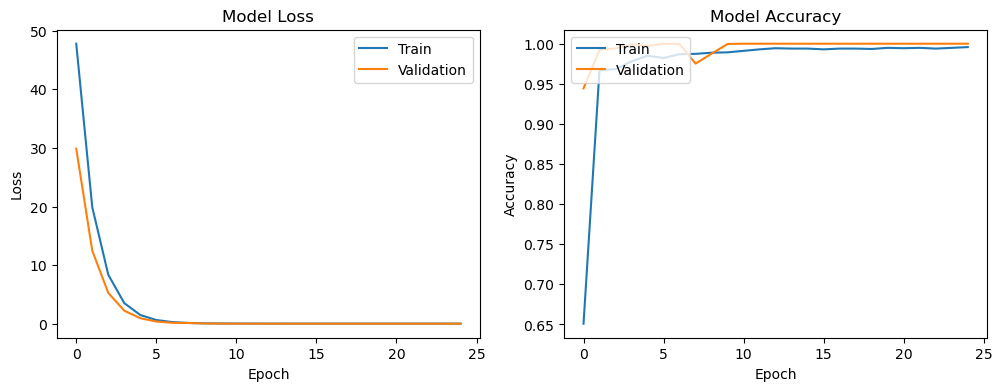

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(_.history['loss'], label='Train')
ax[0].plot(_.history['val_loss'], label='Validation')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(_.history['accuracy'], label='Train')
ax[1].plot(_.history['val_accuracy'], label='Validation')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')

plt.show()
plt.savefig('/kaggle/working/results.png')

In [13]:
from tensorflow.keras.models import load_model
model=load_model("/kaggle/input/modelcnncedar/final_model_CEDAR.h5")

In [23]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-y7pq0awf
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-y7pq0awf
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 24.9 MB/s eta 0:00:0000:01
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13737 sha256=298b9aea36fd76c9c6da79ed37067076cc75c44cd726679f9d6ec37268d0ca4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_omcriwy/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


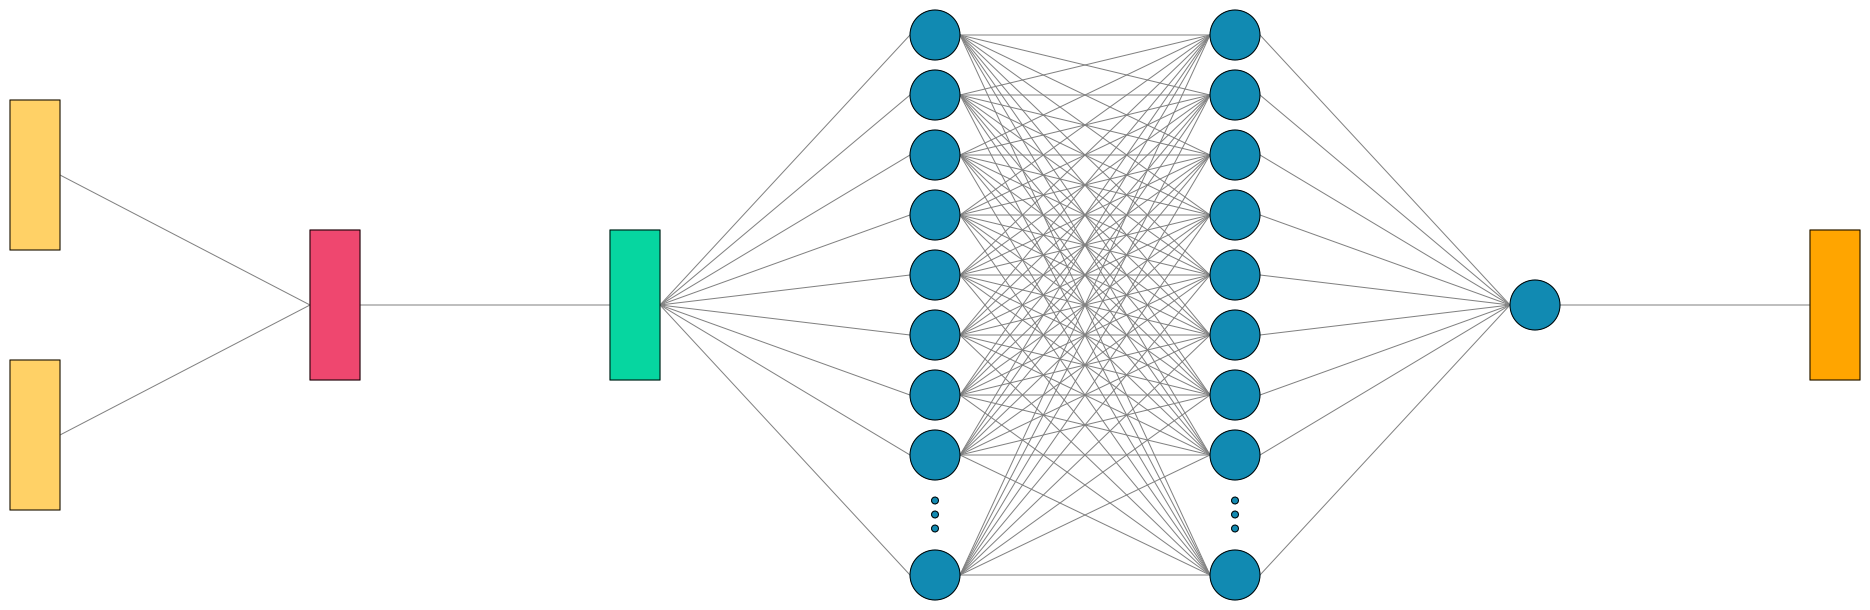

In [48]:
from collections import defaultdict
import visualkeras

color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.graph_view(model, color_map=color_map)

In [19]:
# from tensorflow.keras.utils import plot_model

# plot_model(
#     model,
#     to_file='/kaggle/working/model_CEDAR.png',
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=True,
#     dpi=1024,
#     layer_range=None,
#     show_layer_activations=True,
# )

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np 

threshold = 0.95
X_pre = [returnImageList(X1_val),returnImageList(X2_val)]
Y_pred = (model.predict(X_pre) >= threshold).astype(int)

882/882 [==============================] - 738s 836ms/step


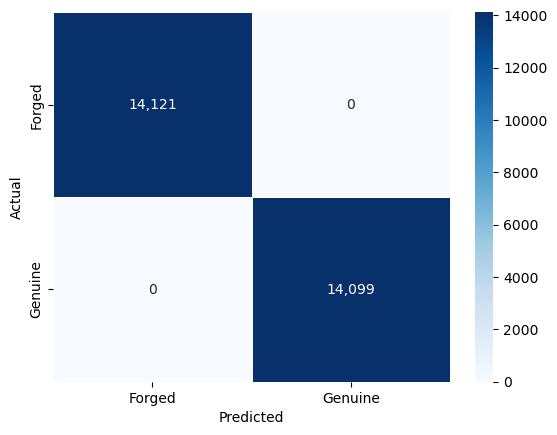

<Figure size 640x480 with 0 Axes>

In [15]:
cm = confusion_matrix(Y_val,Y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cmap='Blues', linewidth=.5, fmt=',.0f'
            , yticklabels=['Forged', 'Genuine'], xticklabels=['Forged', 'Genuine']
           )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig('/kaggle/working/cm.png')

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14121
         1.0       1.00      1.00      1.00     14099

    accuracy                           1.00     28220
   macro avg       1.00      1.00      1.00     28220
weighted avg       1.00      1.00      1.00     28220

Accuracy Score:  1.0
F1 Score:  1.0
Precision Score:  1.0
Recall Score:  1.0


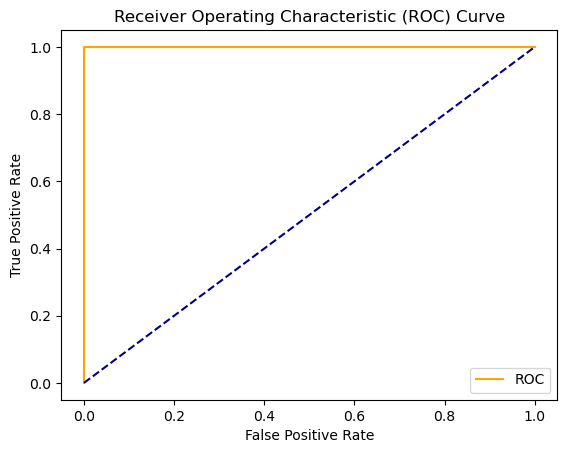

In [62]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, plot_roc_curve
print('Classification Report: \n', classification_report(Y_val, Y_pred))
print('Accuracy Score: ',accuracy_score(Y_val, Y_pred, normalize=True))
print('F1 Score: ', f1_score(Y_val, Y_pred, average="micro"))
print('Precision Score: ',precision_score(Y_val, Y_pred, average="macro"))
print('Recall Score: ', recall_score(Y_val, Y_pred, average="macro"))

def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
probs = Y_pred  
fper, tper, thresholds = roc_curve(Y_val, probs) 
plot_roc_cur(fper, tper)

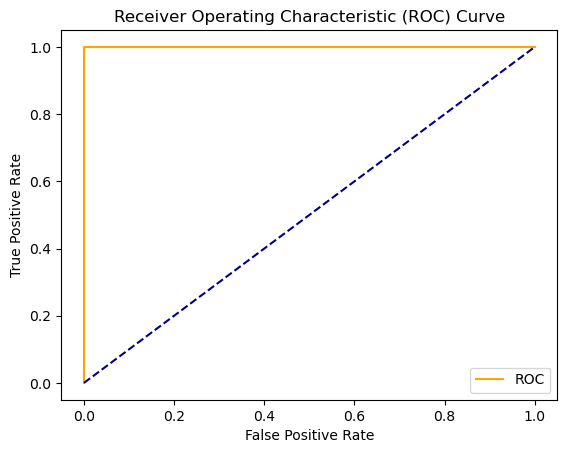

In [22]:
# print(accuracy_score(Y_train, Y_pred, normalize=True))

In [23]:
# print(f1_score(Y_train, Y_pred, average="micro"))

In [24]:
# print(precision_score(Y_train, Y_pred, average="macro"))

In [25]:
# print(recall_score(Y_train, Y_pred, average="macro"))

### **On Training Set**
(Accuracy suggests that the model has avoided overfitting along with learning)

In [26]:
train_set_accuracy = model.evaluate(data_generator(batch_size,X1_train,X2_train,Y_train),batch_size=batch_size,steps=len(Y_val) // batch_size)

2822/2822 [==============================] - 31s 11ms/step - loss: 0.0362 - accuracy: 1.0000


In [27]:
print("Training Set Accuracy is : ", train_set_accuracy[1]*100)

Training Set Accuracy is :  100.0


### **On Validation Set**
(Accuracy suggests how well the model has actually learnt)

In [28]:
validation_set_accuracy=model.evaluate(data_generator(batch_size,X1_val,X2_val,Y_val),batch_size=batch_size,steps=len(Y_val) // batch_size)

2822/2822 [==============================] - 31s 11ms/step - loss: 0.0364 - accuracy: 1.0000


In [29]:
print("Validation Set Accuracy = ",validation_set_accuracy[1]*100)

Validation Set Accuracy =  100.0


### **On Dataset which is totally new for the model**
(Expected Accuracy is very low, just to get an idea on how well the model has learnt)

In [30]:
test_preds = model.predict([returnImageList(set1_X1),returnImageList(set1_X2)])

NameError: name 'set1_X1' is not defined

In [ ]:
def calculateAccuracy(Y,predictions,threshold): # Calculates Accuracy on a given threshold value
    test_preds_final = []
    for i in predictions:
        if i[0]<0.35: test_preds_final.append(0)
        else: test_preds_final.append(1)

    counter=0
    for i in range(0,len(set1_Y)):
        if set1_Y[i] == test_preds_final[i]:
            counter+=1
    return counter*100/len(test_preds_final)

In [ ]:
mean = np.mean(test_preds)
print(mean)

In [ ]:
print("Accuracy gained by the totally new dataset is : ",calculateAccuracy(set1_Y,test_preds,np.mean(test_preds)))